## Word Cloud

- NAVER 신문 crawling (2020.10.01 ~ 2020.10.31)
- 정치, 경제 분야 title (중복기사 제거)
- Word Cloud
- 모든 신문사의 모든 10월 정치, 경제 기사를 크롤링하기 때문에 느립니다.
- **맥 기반에서 작업하여 윈도우에서 실행 시 차이가 있을 수 있습니다**

In [1]:
import requests
from IPython.core.display import display
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
url = "https://news.naver.com/main/officeList.nhn"
# 크롤링 차단하고 있으므로 User-Agent 지정하여 우회
html = requests.get(url, headers={"User-Agent" : "Mozilla/5.0"})
soup = BeautifulSoup(html.text, 'html.parser')

# 신문 제공사 딕셔너리
# 신문사이름: 신문사번호
newspapers = {}

# css selector 이용하여 파싱
for ele in soup.select('ul.group_list a'):
    newspapers[ele.text] = (ele['href'].split('&oid=')[1])

# 파라미터 붙어서 수동할당
newspapers['연합뉴스'] = '001'

print(newspapers)

{'경향신문': '032', '국민일보': '005', '동아일보': '020', '문화일보': '021', '서울신문': '081', '세계일보': '022', '조선일보': '023', '중앙일보': '025', '한겨레': '028', '한국일보': '469', '뉴스1': '421', '뉴시스': '003', '연합뉴스': '001', '연합뉴스TV': '422', '채널A': '449', '한국경제TV': '215', 'JTBC': '437', 'KBS': '056', 'MBC': '214', 'MBN': '057', 'SBS': '055', 'SBS CNBC': '374', 'TV조선': '448', 'YTN': '052', '매일경제': '009', '머니투데이': '008', '서울경제': '011', '아시아경제': '277', '이데일리': '018', '조선비즈': '366', '조세일보': '123', '파이낸셜뉴스': '014', '한국경제': '015', '헤럴드경제': '016', '노컷뉴스': '079', '더팩트': '629', '데일리안': '119', '머니S': '417', '미디어오늘': '006', '아이뉴스24': '031', '오마이뉴스': '047', '프레시안': '002', '디지털데일리': '138', '디지털타임스': '029', '블로터': '293', '전자신문': '030', 'ZDNet Korea': '092', '레이디경향': '145', '매경이코노미': '024', '시사IN': '308', '시사저널': '586', '신동아': '262', '월간 산': '094', '이코노미스트': '243', '주간경향': '033', '주간동아': '037', '주간조선': '053', '중앙SUNDAY': '353', '한겨레21': '036', '한경비즈니스': '050', '기자협회보': '127', '뉴스타파': '607', '동아사이언스': '584', '여성신문': '310', '일다': '00

In [3]:
import pandas as pd

daterange = pd.date_range(start='20101001', end='20101031').strftime('%Y%m%d')
datarange = [str(date) for date in daterange]

In [4]:
# from selenium import webdriver
# driver = webdriver.Chrome("/usr/local/bin/chromedriver")

In [5]:
from datetime import datetime
# 위 출력된 리스트 중 하나 산택
# company = '동아일보'

def startparse(company):

    # 정치, 경제, 사회, 생활/문화, 세계, IT/과학, 오피니언 중 선택
    # subject = '정치'

    # 분류 딕셔너리
    sids = {'정치': '100', '경제': '101'} # '사회': '102', '생활/문화': '103', '세계': '104', 'IT/과학': '105', '오피니언': '110'}

    # 신문사 넘버
    company_num = newspapers[company]

    # 분야 번호
    # sid = sids[subject]

    # dataFrame dictionary
    # news = {'신문사': [], '제목': [], 'link': []}

    result_list = {'정치': set(), '경제': set()}

    for date in daterange:
        for sid in sids:
            # 뉴스 페이지들 끝 번호 알아내기
            url = "https://news.naver.com/main/list.nhn?mode=LPOD&listType=title&sid1={}&mid=sec&oid={}&date={}&page=9999".format(sids[sid], company_num, date)
            html = requests.get(url, headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36'})
            soup = BeautifulSoup(html.text, 'html.parser')
            pages = soup.select('div.paging strong')

            lastpage = int(pages[-1].text)

            # 각 페이지마다
            for page in range(lastpage):
                list_url = "https://news.naver.com/main/list.nhn?mode=LPOD&listType=title&sid1={}&mid=sec&oid={}&date={}&page={}".format(sids[sid], company_num, date, page)
                list_html = requests.get(list_url, headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36'})
                list_soup = BeautifulSoup(list_html.text, 'html.parser')

                # print(list_url)

                # 뉴스 인덱스
                elem_index = 0
                # 각 뉴스 기사마다
                for element in list_soup.select('div.list_body ul a'):

                    if element.find('img') is not None:
                        continue

                    try:
                        article_date = list_soup.select('span.date')[elem_index].text
                        article_date = article_date.split('. ')[0]
                        article_date = datetime.strptime(article_date, '%Y.%m.%d')
                    except:
                        print('리스트 파싱 과정에서 오류 발생')
                        break

                    if article_date != datetime.strptime(date, '%Y%m%d'):
                        # print('다음 기사는 날짜가 다르므로 무시합니다', pd.to_datetime(article_date),pd.to_datetime(date))
                        elem_index += 1
                        continue

                    # print('추가: ', sid, element.text)

                    if sid == '정치':
                        result_list['정치'].add(element.text)
                    elif sid == '경제':
                        result_list['경제'].add(element.text)

                    elem_index += 1

    result_list = {'정치': list(result_list['정치']), '경제': list(result_list['경제'])}
    print(company, '끝')
    return result_list

In [6]:
import pandas as pd
from multiprocessing import Pool

# 테스트용으로 언론사 일부만 (아래 주석 해제)
# newspapers = {'경향신문': '032', '국민일보': '005', '동아일보': '020'}

# 테스트용으로 10월 1일부터 2일까지만 (아래 주석 두줄 해제)
# daterange = pd.date_range(start='20101001', end='20101002').strftime('%Y%m%d')
# datarange = [str(date) for date in daterange]

result_list = {'정치':[], '경제':[]}

# pool = Pool(processes=1) # 4개의 프로세스를 사용합니다.
# returndata = pool.map(startparse, list(newspapers))
# pool.close()

for newspaper in newspapers:
    _result = startparse(newspaper)
    result_list['정치'].extend(_result['정치'])
    result_list['경제'].extend(_result['경제'])

경향신문 끝
국민일보 끝
동아일보 끝
문화일보 끝
서울신문 끝
세계일보 끝
조선일보 끝
중앙일보 끝
한겨레 끝
한국일보 끝
뉴스1 끝
뉴시스 끝
연합뉴스 끝
연합뉴스TV 끝
채널A 끝
한국경제TV 끝
JTBC 끝
KBS 끝
MBC 끝
MBN 끝
SBS 끝
SBS CNBC 끝
TV조선 끝
YTN 끝
매일경제 끝
머니투데이 끝
서울경제 끝
아시아경제 끝
이데일리 끝
조선비즈 끝
조세일보 끝
파이낸셜뉴스 끝
한국경제 끝
헤럴드경제 끝
노컷뉴스 끝
더팩트 끝
데일리안 끝
머니S 끝
미디어오늘 끝
아이뉴스24 끝
오마이뉴스 끝
프레시안 끝
디지털데일리 끝
디지털타임스 끝
블로터 끝
전자신문 끝
ZDNet Korea 끝
레이디경향 끝
매경이코노미 끝
시사IN 끝
시사저널 끝
신동아 끝
월간 산 끝
이코노미스트 끝
주간경향 끝
주간동아 끝
주간조선 끝
중앙SUNDAY 끝
한겨레21 끝
한경비즈니스 끝
기자협회보 끝
뉴스타파 끝
동아사이언스 끝
여성신문 끝
일다 끝
코리아중앙데일리 끝
코리아헤럴드 끝
코메디닷컴 끝
헬스조선 끝
강원일보 끝
매일신문 끝
부산일보 끝
신화사 연합뉴스 끝
AP연합뉴스 끝
EPA연합뉴스 끝


In [7]:
t1 = pd.Series(result_list['정치'], name='정치')
t2 = pd.Series(result_list['경제'], name='경제')
df = pd.concat([t1,t2], axis=1)
display(df)

df.to_csv('네이버 뉴스.csv', encoding='utf-8-sig', index=False)

,정치,경제
0,"“북 급변사태시, 난민 軍 임시수용 뒤 정부 이관”","STX, 사우디서 11억달러 유화 플랜트 수주"
1,[포토뉴스]손잡은 진보 양당,노후는 이렇게! 동대문상가 분양 받아 노후를... 등기분양상가 골라야!
2,"유인촌, “내가 장관 오래하지 않으니” 말했다가…",[알짜 재테크]엄선된 투자자문사 자문에 따라 운용
3,“담뱃값 올려 OECD 최고 흡연율 줄이겠다”,"김천과학대학, 일본 운젠여관호텔조합과 산학협력협약 체결"
4,[국감 현장]충청권 “교육감 직선제 폐지 반대” 한목소리,[가족친화경영]가스공사 - 주말·휴가마다 떠나는 사랑의 캠프
...,...,...
79255,NaN,"""전국 51개 노후 산단, 선진국형 기업밸리로"""
79256,NaN,녹색식생활 조례 추진을 스코틀랜드·로마 성공사례… 부산도 본격화
79257,NaN,[포토뉴스] 요트가 좋아요
79258,NaN,싱가포르·호주 증시 통합


In [8]:
from wordcloud import WordCloud, STOPWORDS

import numpy as np
from PIL import Image

In [9]:
text = open('네이버 뉴스.csv').read()
alice_mask = np.array(Image.open('12주차_한국어분석/alice_mask.png'))

stopwords = set(STOPWORDS)
stopwords.add("said")

### matplotlib에 한글폰트 설치

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import platform

from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    matplotlib.rc('font', family='NanumSquare')
    # 유니코드에서  음수 부호설정
    matplotlib.rc('axes', unicode_minus=False)
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

# %matplotlib inline

In [11]:
# plt.figure(figsize=(8,8))
# plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
# plt.axis('off')
# plt.show()

### csv에서 단어 count

In [12]:
# 여기서도 글꼴 지정해줘야함 (맥에서는)
wc = WordCloud(background_color='white',
               font_path="/Library/Fonts/NanumBarunGothic.ttf",
               max_words=2000,
               mask=alice_mask,
                stopwords = stopwords)
wc = wc.generate(text)
wc.words_

{'국감': 1.0,
 '2010국감': 0.5604395604395604,
 '종합': 0.5002197802197802,
 '등': 0.49274725274725273,
 '특징주': 0.4413186813186813,
 '中': 0.39384615384615385,
 '사진': 0.38857142857142857,
 '출시': 0.33582417582417584,
 '美': 0.30813186813186816,
 '정부': 0.30153846153846153,
 '포토': 0.28703296703296705,
 '한국': 0.2672527472527473,
 '개최': 0.2602197802197802,
 'G20': 0.22505494505494505,
 '것': 0.21626373626373627,
 '3Q 영업익': 0.21318681318681318,
 '첫': 0.20703296703296703,
 '삼성전자': 0.2021978021978022,
 '3분기 영업익': 0.1991208791208791,
 '지원': 0.19516483516483515,
 '증가': 0.19076923076923077,
 'VOD': 0.1898901098901099,
 '日': 0.18725274725274726,
 '추진': 0.18417582417582418,
 '국정감사': 0.18065934065934067,
 '北': 0.17186813186813188,
 '더': 0.16835164835164834,
 '글로벌': 0.16615384615384615,
 '상보': 0.16615384615384615,
 '판매': 0.16483516483516483,
 '논란': 0.16439560439560438,
 '김황식 총리': 0.1621978021978022,
 '내년': 0.15692307692307692,
 '기업': 0.15252747252747254,
 '중국': 0.15208791208791209,
 '투자': 0.15164835164835164,


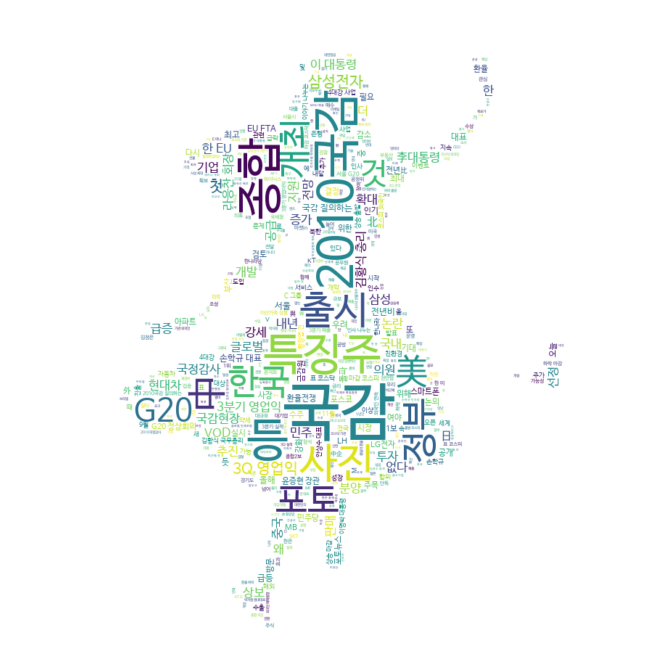

In [13]:
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()